In [1]:
from markov_chain import SimpleSymmetricRandomWalk, get_samples_from_mean_estimator_for_inverse_square, inverse_square
from bootstrap import rbb_parallel_apply_async
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Prepare style for the plots
sns.set_style("whitegrid")
sns.set_context("paper")

In [3]:
# Random seed for reproducibility
random_seed = 10
np.random.seed(random_seed)

In [4]:
# Variables
n_steps = 10**6
num_bootstraps = 10**3
true_mean = (np.pi**2)/3

In [5]:
simple_symmetric_random_walk = SimpleSymmetricRandomWalk(step_n=n_steps, name="simple_rw", random_seed=random_seed)

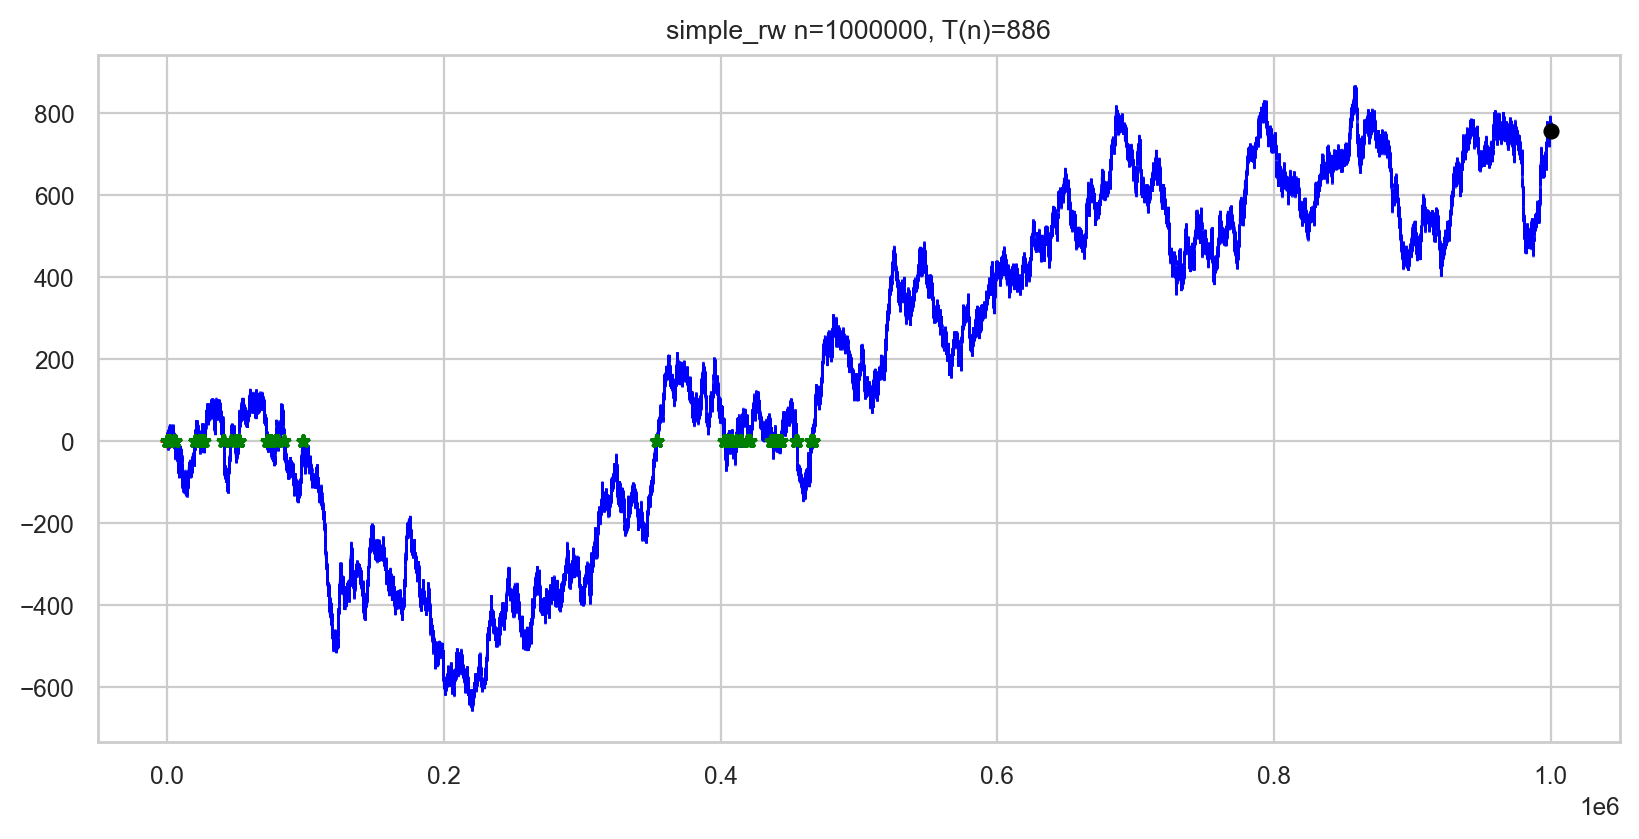

In [6]:
simple_symmetric_random_walk.plot_simulation(save=False, state=0)

In [7]:
regeneration_block_sizes = simple_symmetric_random_walk.get_regeneration_block_sizes(state=0)

In [8]:
fn_blocks = simple_symmetric_random_walk.apply_fn_regeneration_blocks(state=0, fn=inverse_square)

/Users/carlos/work/phd-code/boostrap_markov/utils/markov_chain/base.py:462: RuntimeWarning: divide by zero encountered in power
  return np.sum(np.where(block == 0, 0, np.power(block, -2)))


In [10]:
fn_bootstraps = rbb_parallel_apply_async(block_sizes=regeneration_block_sizes, block_values=fn_blocks, n=n_steps, num_bootstraps=num_bootstraps)

In [11]:
len(fn_bootstraps)

1000

In [15]:
for f_b in fn_bootstraps:
    print(len(f_b))

1886
2474
3460
3280
1518
2182
2323
1351
1224
572
1172
2225
2896
2888
2082
1103
1740
1519
2643
717
1171
2853
1468
2463
1919
2756
1414
2490
2204
2005
973
3116
1902
2139
758
2812
2837
800
1715
2116
1393
2947
897
808
2947
1658
2075
1713
1890
2464
1118
2184
2200
3805
3194
1181
1441
810
3863
1245
2743
2900
1955
1350
2491
3720
1543
4311
2435
1820
2550
1599
1944
2118
1999
2281
2257
2756
1648
557
1106
2472
1488
1243
1846
2247
2384
2458
2370
1005
1676
1211
2038
1699
799
1338
2061
1752
2088
3024
1899
1685
1541
381
1864
1576
992
2639
3091
1235
1920
3096
1609
3123
1556
1893
2492
3326
977
1743
2028
3008
1070
2348
2316
1523
2008
2308
2792
2468
2155
2059
3161
2133
1425
1879
1208
2710
1699
2096
3199
1294
1382
1043
1632
2661
1588
2634
3905
1602
1738
1509
1915
1090
1464
1814
2342
2106
1012
1203
3070
2124
2048
2679
1908
2024
1566
1881
2507
1261
2982
1859
1722
1448
2242
1922
1593
1279
1364
2141
1140
2967
1899
1160
2143
2044
2250
1651
2404
1000
1573
1575
1532
2815
1681
2501
1974
1897
2207
2085
2059
1724
460